In [1]:
import os
import sys , time , traceback  , itertools , ipdb
import datetime as dt
from pprint import pprint
from tqdm import tqdm
import warnings , ipdb
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl



import tsalib , common

In [2]:
%matplotlib notebook

In [3]:
date='2019-05-12'

ticker = 'FB'
data = tsalib.get_data(date=date,ticker=ticker,data_source='web',horizon=22)
vix = tsalib.get_data(date=date,ticker='^VIX',data_source='web',horizon=22)

{'model': {'sim_id': 'c7c197af-ca0a-413b-8ec5-bf3a50b8ea52', 'ticker': 'FB', 'arch_model': 'EGARCH', 'sim_prc': 0.1, 'method': 'simulation', 'dist': 'StudentsT', 'arch_params': (3, 3), 'mean_model': 'Constant', 'date': '2019-05-10', 'prev_month_vola': 7.13, 'expected_var_d': 10.31, 'real_vola': 0, 'predicted_range': array([181.27880373, 188.26750593, 195.17991182, 205.16664475])}, 'stats': {'null_rmse': 1.0, 'arch_sim_rmse': 1.0}}


<IPython.core.display.Javascript object>


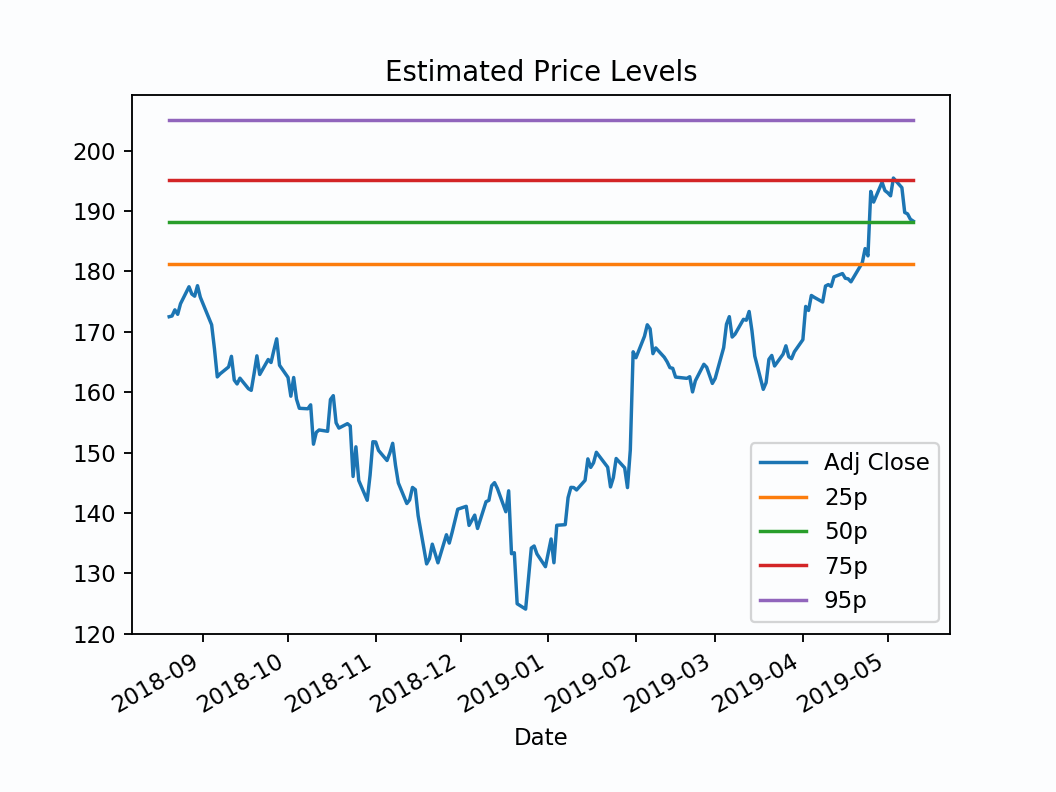

In [4]:
years = 10
month = 12

ticker=ticker
sim_prc=0.1
model='EGARCH'
arch_params=(3,3)
#mean_model='ARX'
#mean_model='HARX'
mean_model='Constant'

method='simulation'
#method= 'bootstrap'

dist='StudentsT'
#dist='normal'
#dist='skewt'

data_source='web'

res = tsalib.eval_model(TS=data
                  ,ticker=ticker
                  ,horizon=22
                  ,model=model
                  ,print_model=False
                  ,sim_prc=sim_prc
                  ,method=method
                  ,arch_params=arch_params
                  ,mean_model=mean_model
                  ,dist=dist
                 ,live=True)

print(res)

vis_data = data.iloc[-182:].copy()
vis_data['25p'] = res['model']['predicted_range'][0]
vis_data['50p'] = res['model']['predicted_range'][1]
vis_data['75p'] = res['model']['predicted_range'][2]
vis_data['95p'] = res['model']['predicted_range'][3]
ax = vis_data[['Adj Close','25p','50p','75p','95p']].plot(title='Estimated Price Levels')

In [ ]:

res = tsalib.test_prediction(n_month_back=month*years
                      ,date=date
                      ,ticker=ticker
                      ,sim_prc=sim_prc
                      ,print_model=False
                      ,model=model
                      ,arch_params=arch_params
                      ,mean_model=mean_model
                      ,method=method
                      ,dist=dist
                      ,data_source=data_source
                      )
time.sleep(1)

sim_df = pd.DataFrame([res['by_month'][i]['model'] for i in range(len(res['by_month']))]).set_index('date')
sim_df.index = pd.to_datetime(sim_df.index)
comb_df = sim_df.join(vix,how='left')

print({'summary':[res['summary'],{'vix_corr':round(np.corrcoef(comb_df['expected_var_d'],comb_df['Adj Close'])[0,1],2)}]})

In [ ]:
sim_df.loc['2018-01-01':'2018-05-01']

In [ ]:
#plt.style.use('seaborn')
sim_df[['prev_month_vola','expected_var_d','real_vola']].plot(title=f'{model} Backtest'
                                                              ,colormap='Paired'
                                                             )


In [ ]:
common.plot_multi(comb_df[['expected_var_d','Adj Close']],title='Simulated SPY Volatility vs VIX',loc='right', figsize=(10, 5))

In [ ]:
#Make a predictions
